In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import pickle
from fair_loss import FairLoss
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score, balanced_accuracy_score,recall_score
import matplotlib.pyplot as plt


In [2]:
import torch
print(torch.__version__)


1.7.1


In [3]:

class LinReLU(nn.Module):
    """
    A linear layer followed by a ReLU activation layer.
    """

    def __init__(self, in_size, out_size):
        super(LinReLU, self).__init__()

        linear = nn.Linear(in_size, out_size)
        ReLU = nn.ReLU()
        # self.Dropout = nn.Dropout(0.25)
        self.layers = nn.Sequential(linear, ReLU)

    def reset_parameters(self):
        self.layers[0].reset_parameters()
        return self

    def forward(self, x):
        x = self.layers(x)
        return x


class FullyConnected(nn.Module):
    """
    A simple fully connected neural network with ReLU activations.
    """

    def __init__(self, input_size, layout):

        super(FullyConnected, self).__init__()
        layers = [nn.Flatten()]  # does not play any role, but makes the code neater
        prev_fc_size = input_size
        for i, fc_size in enumerate(layout):
            if i + 1 < len(layout):
                layers += [LinReLU(prev_fc_size, fc_size)]
            else:
                layers += [nn.Linear(prev_fc_size, fc_size)]
            prev_fc_size = fc_size
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x



In [4]:
client_data_dir='../clients_data/client_subG_processed/'


layout = [100, 100, 2]
batch_size = 32
num_epochs = 15
input_dim = 105
lr = 0.01

model = FullyConnected(input_dim, layout)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [5]:
client_models = [0,1,2,3]
client_models = [0]
group_and_subgroup = {
    "testing_data_group": ["male", "female", "white", "black"],
    "testing_data_subgroup": ["WM", "WW", "BM", "BW"]
}

final_result_group = {str(model_name): {} for model_name in client_models}
final_result_subgroup = {str(model_name): {} for model_name in client_models}

In [6]:

def process_test_data(test_split, model, criterion):
    with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
        test_data = pickle.load(f)
    
    total_length = sum(len(batch[0]) for batch in test_data)
    print(f"Total length of {test_split} test data: {total_length}")
    
    all_labels, all_predicted_classes = [], []
    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        for inputs, labels in test_data:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted_classes = torch.max(outputs, dim=1)
            val_correct += (predicted_classes == labels).sum().item()
            val_total += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_predicted_classes.extend(predicted_classes.cpu().numpy())
            
        val_epoch_loss = val_running_loss / len(test_data)
        val_accuracy = val_correct / val_total
        
    all_labels = np.array(all_labels)
    all_predicted_classes = np.array(all_predicted_classes)
    
    f1 = f1_score(all_labels, all_predicted_classes, average="weighted")
    balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
    tpr = recall_score(all_labels, all_predicted_classes, average="weighted")
    
    return tpr, f1, balanced_acc, val_epoch_loss, val_accuracy


# Normal Traning

In [8]:

for model_name in client_models:
    print(f"------------------------ Processing model: {model_name}-------------------------")
    # Load the trained model for the current client
    model.load_state_dict(torch.load(f'../clients_data/clients_trained_model/client{model_name}.pth'))
    
    print("========================== SubGroup ====================================")
    # Process subgroups
    for test_split in group_and_subgroup["testing_data_subgroup"]:
        print(f"Evaluating subgroup test split: {test_split}")
        tpr, f1, balanced_acc, val_epoch_loss, val_accuracy = process_test_data(test_split, model, criterion)
        final_result_subgroup[str(model_name)][test_split] = tpr
        print(f"Subgroup {test_split} - TPR: {tpr:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    
    print("========================== Group ====================================")
    # Process groups
    for test_split in group_and_subgroup["testing_data_group"]:
        print(f"Evaluating group test split: {test_split}")
        tpr, f1, balanced_acc, val_epoch_loss, val_accuracy = process_test_data(test_split, model, criterion)
        final_result_group[str(model_name)][test_split] = tpr
        print(f"Group {test_split} - TPR: {tpr:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Output the results
print("\nFinal Results for Subgroups:")
print(final_result_subgroup)
print("\nFinal Results for Groups:")
print(final_result_group)

------------------------ Processing model: 0-------------------------
========================== SubGroup ====================================
Evaluating subgroup test split: WM
Total length of WM test data: 5975
Subgroup WM - TPR: 0.6772, F1: 0.5468, Balanced Accuracy: 0.5000, Loss: 0.6328, Accuracy: 0.6772
Evaluating subgroup test split: WW
Total length of WW test data: 2628
Subgroup WW - TPR: 0.8775, F1: 0.8202, Balanced Accuracy: 0.5000, Loss: 0.5510, Accuracy: 0.8775
Evaluating subgroup test split: BM
Total length of BM test data: 474
Subgroup BM - TPR: 0.7954, F1: 0.7047, Balanced Accuracy: 0.5000, Loss: 0.5711, Accuracy: 0.7954
Evaluating subgroup test split: BW
Total length of BW test data: 461
Subgroup BW - TPR: 0.9219, F1: 0.8844, Balanced Accuracy: 0.5000, Loss: 0.5113, Accuracy: 0.9219
========================== Group ====================================
Evaluating group test split: male
Total length of male test data: 6750
Group male - TPR: 0.6880, F1: 0.5608, Balanced Acc

In [9]:

filename_group = "inversion_adult_group_normal_fairness.pickle"
filename_subgroup = "inversion_adult_subgroup_normal_fairness.pickle"

with open(filename_group, 'wb') as file:
    pickle.dump(final_result_group, file)

with open(filename_subgroup, 'wb') as file:
    pickle.dump(final_result_subgroup, file)

print(f"Data has been stored in {filename_group}")
print(f"Data has been stored in {filename_subgroup}")

Data has been stored in inversion_adult_group_normal_fairness.pickle
Data has been stored in inversion_adult_subgroup_normal_fairness.pickle


# DP training 

In [10]:

for model_name in client_models:
    print(f"------------------------ Processing model: {model_name}-------------------------")
    model.load_state_dict(torch.load(f'../clients_data/client_DP_trained_model/client{model_name}.pth'))
    
    print("========================== SubGroup ====================================")
    # Process subgroups
    for test_split in group_and_subgroup["testing_data_subgroup"]:
        print(f"Evaluating subgroup test split: {test_split}")
        tpr, f1, balanced_acc, val_epoch_loss, val_accuracy = process_test_data(test_split, model, criterion)
        final_result_subgroup[str(model_name)][test_split] = tpr
        print(f"Subgroup {test_split} - TPR: {tpr:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    
    print("========================== Group ====================================")
    # Process groups
    for test_split in group_and_subgroup["testing_data_group"]:
        print(f"Evaluating group test split: {test_split}")
        tpr, f1, balanced_acc, val_epoch_loss, val_accuracy = process_test_data(test_split, model, criterion)
        final_result_group[str(model_name)][test_split] = tpr
        print(f"Group {test_split} - TPR: {tpr:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Output the results
print("\nFinal Results for Subgroups:")
print(final_result_subgroup)
print("\nFinal Results for Groups:")
print(final_result_group)

------------------------ Processing model: 0-------------------------
========================== SubGroup ====================================
Evaluating subgroup test split: WM
Total length of WM test data: 5975
Subgroup WM - TPR: 0.6688, F1: 0.6189, Balanced Accuracy: 0.5431, Loss: 0.6766, Accuracy: 0.6688
Evaluating subgroup test split: WW
Total length of WW test data: 2628
Subgroup WW - TPR: 0.8067, F1: 0.8032, Balanced Accuracy: 0.5331, Loss: 0.6685, Accuracy: 0.8067
Evaluating subgroup test split: BM
Total length of BM test data: 474
Subgroup BM - TPR: 0.7806, F1: 0.7437, Balanced Accuracy: 0.5558, Loss: 0.6628, Accuracy: 0.7806
Evaluating subgroup test split: BW
Total length of BW test data: 461
Subgroup BW - TPR: 0.8677, F1: 0.8589, Balanced Accuracy: 0.4833, Loss: 0.6544, Accuracy: 0.8677
========================== Group ====================================
Evaluating group test split: male
Total length of male test data: 6750
Group male - TPR: 0.6744, F1: 0.6255, Balanced Acc

In [11]:

filename_group = "inversion_adult_group_dp_fairness.pickle"
filename_subgroup= "inversion_adult_subgroup_dp_fairness.pickle"

with open(filename_group, 'wb') as file:
    pickle.dump(final_result_group, file)

with open(filename_subgroup, 'wb') as file:
    pickle.dump(final_result_subgroup, file)

print(f"Data has been stored in {filename_group}")
print(f"Data has been stored in {filename_subgroup}")

Data has been stored in inversion_adult_group_dp_fairness.pickle
Data has been stored in inversion_adult_subgroup_dp_fairness.pickle


# fair Training

In [12]:

for model_name in client_models:
    print(f"------------------------ Processing model: {model_name}-------------------------")
    # Load the trained model for the current client
    model.load_state_dict(torch.load(f'../clients_data/clients_fair_trained_model/client{model_name}.pth'))
    
    print("========================== SubGroup ====================================")
    # Process subgroups
    for test_split in group_and_subgroup["testing_data_subgroup"]:
        print(f"Evaluating subgroup test split: {test_split}")
        tpr, f1, balanced_acc, val_epoch_loss, val_accuracy = process_test_data(test_split, model, criterion)
        final_result_subgroup[str(model_name)][test_split] = tpr
        print(f"Subgroup {test_split} - TPR: {tpr:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    
    print("========================== Group ====================================")
    # Process groups
    for test_split in group_and_subgroup["testing_data_group"]:
        print(f"Evaluating group test split: {test_split}")
        tpr, f1, balanced_acc, val_epoch_loss, val_accuracy = process_test_data(test_split, model, criterion)
        final_result_group[str(model_name)][test_split] = tpr
        print(f"Group {test_split} - TPR: {tpr:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Output the results
print("\nFinal Results for Subgroups:")
print(final_result_subgroup)
print("\nFinal Results for Groups:")
print(final_result_group)

------------------------ Processing model: 0-------------------------
========================== SubGroup ====================================
Evaluating subgroup test split: WM
Total length of WM test data: 5975
Subgroup WM - TPR: 0.6782, F1: 0.6470, Balanced Accuracy: 0.5730, Loss: 0.6772, Accuracy: 0.6782
Evaluating subgroup test split: WW
Total length of WW test data: 2628
Subgroup WW - TPR: 0.8143, F1: 0.8115, Balanced Accuracy: 0.5535, Loss: 0.6685, Accuracy: 0.8143
Evaluating subgroup test split: BM
Total length of BM test data: 474
Subgroup BM - TPR: 0.7722, F1: 0.7433, Balanced Accuracy: 0.5620, Loss: 0.6645, Accuracy: 0.7722
Evaluating subgroup test split: BW
Total length of BW test data: 461
Subgroup BW - TPR: 0.8785, F1: 0.8672, Balanced Accuracy: 0.5019, Loss: 0.6542, Accuracy: 0.8785
========================== Group ====================================
Evaluating group test split: male
Total length of male test data: 6750
Group male - TPR: 0.6803, F1: 0.6497, Balanced Acc

In [13]:

filename_group = "inversion_adult_group_fair_fairness.pickle"
filename_subgroup = "inversion_adult_subgroup_fair_fairness.pickle"

with open(filename_group, 'wb') as file:
    pickle.dump(final_result_group, file)

with open(filename_subgroup, 'wb') as file:
    pickle.dump(final_result_subgroup, file)

print(f"Data has been stored in {filename_group}")
print(f"Data has been stored in {filename_subgroup}")

Data has been stored in inversion_adult_group_fair_fairness.pickle
Data has been stored in inversion_adult_subgroup_fair_fairness.pickle


# FairDP training

In [14]:

for model_name in client_models:
    print(f"------------------------ Processing model: {model_name}-------------------------")
    
    model.load_state_dict(torch.load(f'../clients_data/clients_DP_Fair_trained_model/client{model_name}.pth'))
    
    print("========================== SubGroup ====================================")
    # Process subgroups
    for test_split in group_and_subgroup["testing_data_subgroup"]:
        print(f"Evaluating subgroup test split: {test_split}")
        tpr, f1, balanced_acc, val_epoch_loss, val_accuracy = process_test_data(test_split, model, criterion)
        final_result_subgroup[str(model_name)][test_split] = tpr
        print(f"Subgroup {test_split} - TPR: {tpr:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    
    print("========================== Group ====================================")
    # Process groups
    for test_split in group_and_subgroup["testing_data_group"]:
        print(f"Evaluating group test split: {test_split}")
        tpr, f1, balanced_acc, val_epoch_loss, val_accuracy = process_test_data(test_split, model, criterion)
        final_result_group[str(model_name)][test_split] = tpr
        print(f"Group {test_split} - TPR: {tpr:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Output the results
print("\nFinal Results for Subgroups:")
print(final_result_subgroup)
print("\nFinal Results for Groups:")
print(final_result_group)

------------------------ Processing model: 0-------------------------
========================== SubGroup ====================================
Evaluating subgroup test split: WM
Total length of WM test data: 5975
Subgroup WM - TPR: 0.6772, F1: 0.5468, Balanced Accuracy: 0.5000, Loss: 0.6212, Accuracy: 0.6772
Evaluating subgroup test split: WW
Total length of WW test data: 2628
Subgroup WW - TPR: 0.8775, F1: 0.8202, Balanced Accuracy: 0.5000, Loss: 0.5108, Accuracy: 0.8775
Evaluating subgroup test split: BM
Total length of BM test data: 474
Subgroup BM - TPR: 0.7954, F1: 0.7047, Balanced Accuracy: 0.5000, Loss: 0.5394, Accuracy: 0.7954
Evaluating subgroup test split: BW
Total length of BW test data: 461
Subgroup BW - TPR: 0.9219, F1: 0.8844, Balanced Accuracy: 0.5000, Loss: 0.4613, Accuracy: 0.9219
========================== Group ====================================
Evaluating group test split: male
Total length of male test data: 6750
Group male - TPR: 0.6880, F1: 0.5608, Balanced Acc

In [15]:

filename_group = "inversion_adult_group_fairDp_fairness.pickle"
filename_subgroup = "inversion_adult_subgroup_fairDp_fairness.pickle"

with open(filename_group, 'wb') as file:
    pickle.dump(final_result_group, file)

with open(filename_subgroup, 'wb') as file:
    pickle.dump(final_result_subgroup, file)

print(f"Data has been stored in {filename_group}")
print(f"Data has been stored in {filename_subgroup}")

Data has been stored in inversion_adult_group_fairDp_fairness.pickle
Data has been stored in inversion_adult_subgroup_fairDp_fairness.pickle


In [16]:
subgrp_exp = False
group_exp = True


if subgrp_exp is True:
    print("Subgrp exp is selected")
    
    normal_train = "inversion_subgroup_normal_fairness.pickle"
    dp_train = "inversion_subgroup_dp_fairness.pickle"
    fair_train = "inversion_subgroup_fair_fairness.pickle"
    fairDP_train = "inversion_subgroup_fairDp_fairness.pickle"
    
if group_exp is True :
    print("group exp is selected")
    
    normal_train = "inversion_adult_group_normal_fairness.pickle"
    dp_train = "inversion_adult_group_dp_fairness.pickle"
    fair_train = "inversion_adult_group_fair_fairness.pickle"
    fairDP_train = "inversion_adult_group_fairDp_fairness.pickle"



with open(normal_train, 'rb') as file:
    normal_train_loaded = pickle.load(file)
with open(dp_train, 'rb') as file:
    dp_train_loaded = pickle.load(file)
with open(fair_train, 'rb') as file:
    fair_train_loaded = pickle.load(file)
with open(fairDP_train, 'rb') as file:
    fairDP_train_loaded = pickle.load(file)




group exp is selected


In [17]:
def subgroup_calculate_state_ratios(data):
    state_names = []
    ratios_list = []
    denominator_list = []
    
    for state, values in data.items():
        # Find maximum value and its key
        max_value = max(values, key=values.get)
        max_value_amount = values[max_value]
        
        # Calculate ratios
        ratios = {}
        for key, value in values.items():
            if key != max_value:  # Exclude the max_value itself
                ratios[key + '/' + max_value] = value / max_value_amount
        
        # Append state data
        state_names.append(state)
        denominator_list.append(max_value)
        ratios_list.append(ratios)
    
    # Create DataFrame with ratios
    df_final = pd.DataFrame(ratios_list).fillna("")
    
    # Add state column
    df_final.insert(0, 'State', state_names)
    
    # Reset index to make sure it's numeric
    df_final = df_final.reset_index(drop=True)
    
    return df_final

In [18]:
def compute_ratios(data_dict):
    results_fixed = []
    for state, values in data_dict.items():
        # female_to_male: ensure female is the numerator
        female_to_male = values['female'] / values['male'] if values['male'] != 0 else None

        # black_to_white: ensure black is the numerator
        black_to_white = values['black'] / values['white'] if values['white'] != 0 else None

        # Append each state's data as a dictionary
        results_fixed.append({
            'State': state,
            'Female_to_Male': female_to_male,
            'Black_to_White': black_to_white
        })
        
    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(results_fixed)

In [19]:
normal_train_loaded

{'0': {'male': 0.688,
  'female': 0.8849230769230769,
  'white': 0.7383470882250378,
  'black': 0.8577540106951872}}

In [20]:
normal_train_df=compute_ratios(normal_train_loaded)
dp_train_df=compute_ratios(dp_train_loaded)
fair_train_df=compute_ratios(fair_train_loaded)
fairDP_train_df=compute_ratios(fairDP_train_loaded)

In [21]:
normal_train_df

,State,Female_to_Male,Black_to_White
0,0,1.286225,1.161722


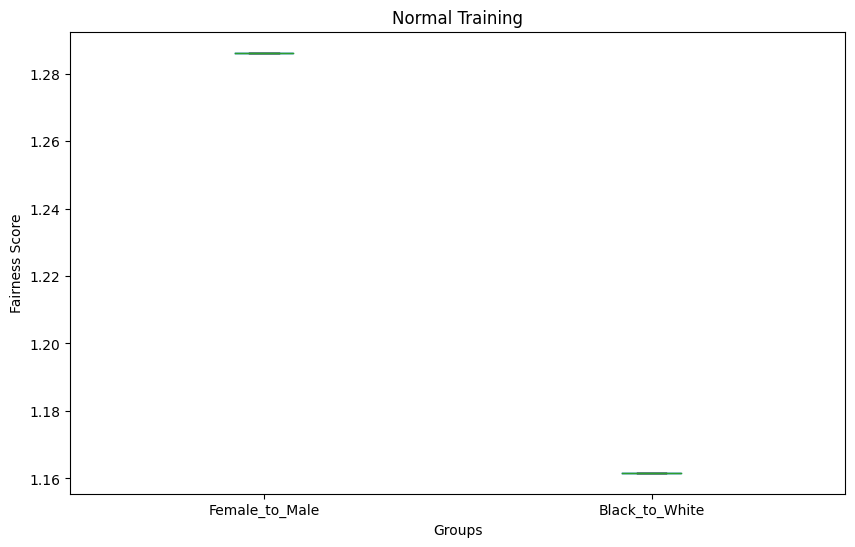

In [22]:
plt.figure(figsize=(10, 6))
normal_train_df.drop("State", axis=1).boxplot()
plt.title("Normal Training")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

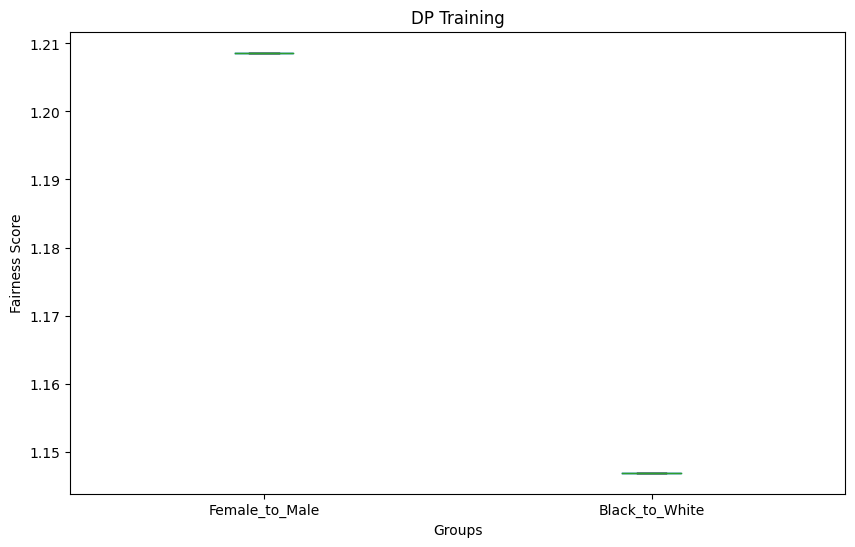

In [23]:
plt.figure(figsize=(10, 6))
dp_train_df.drop("State", axis=1).boxplot()
plt.title("DP Training")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

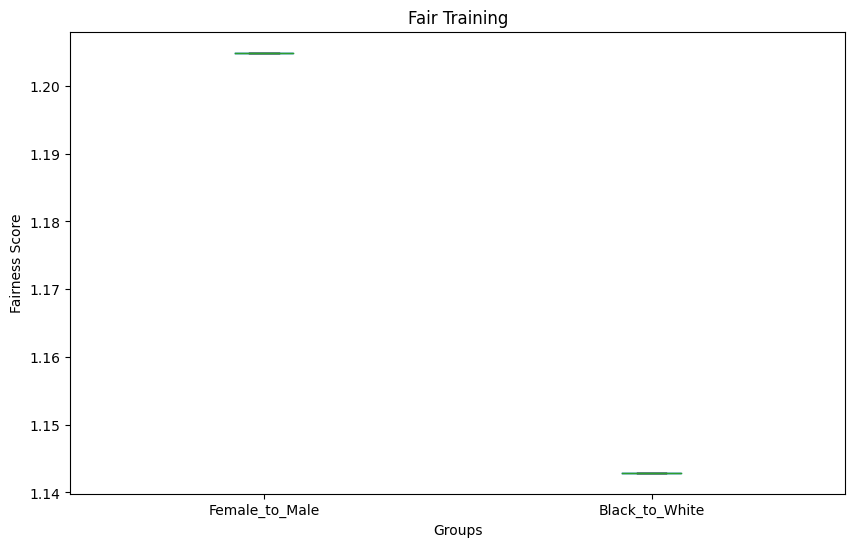

In [24]:
plt.figure(figsize=(10, 6))
fair_train_df.drop("State", axis=1).boxplot()
plt.title("Fair Training")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

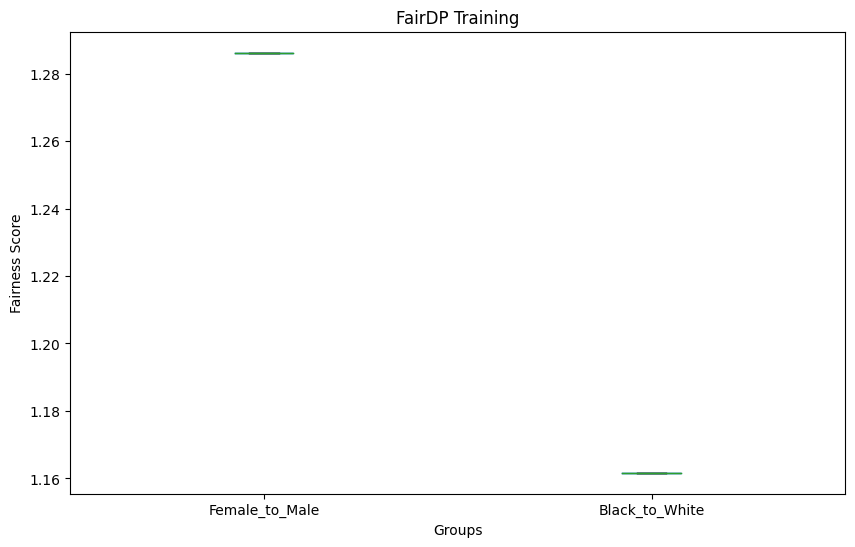

In [25]:
plt.figure(figsize=(10, 6))
fairDP_train_df.drop("State", axis=1).boxplot()
plt.title("FairDP Training")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()